# REGRESSION: Bitcoin Price Forecast

***


## INTRODUCTION

This project used data from <b style="color:#4361ee">Kraken API</b> and initially applid one machine learning model, <b style="color:#4361ee">Support Vector Machine</b>, to forcast the future price of <b style="color:#4361ee">Bitcoin.</b>

In [346]:
import numpy as np
import pandas as pd
import json
import datetime
import time
import requests

In [347]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams["font.size"]=14
matplotlib.rcParams["figure.figsize"]= (18,8)
matplotlib.rcParams["figure.facecolor"]="#00000000"

import seaborn as sns
sns.set_style("darkgrid")
import plotly.express as px

## DATA COLLECTION

Kraken gives historical cryptocurrency data. However, the current historical data available is March 31, 2022.
Therefore, additional data need to be pulled from the API market data endpoint.

### 1. Kraken Historical OHLCVT 

* https://support.kraken.com/hc/en-us/articles/360047124832-Downloadable-historical-OHLCVT-Open-High-Low-Close-Volume-Trades-data

* The data given is in one minute timeframe, so we will use the 1440 (daily timeframe)
* The date is in Unix timestamp, so need to be converted to regular date time 

In [348]:
# The columns from the csv file
xbt_cols = ["date","open", "high", "low", "close", "volume", "trades"]

In [349]:
xbt_raw = pd.read_csv("data/XBTUSD_1440.csv", names=xbt_cols)

In [350]:
# Convert Unix timestamp
xbt_raw["date"] = pd.to_datetime(xbt_raw["date"],unit='s')

In [351]:
xbt_raw.to_csv("data/xbt_raw.csv")

### 2. Kraken API Market data OHLC endpoint
* Using OHLC endpoint for 2022 data
* https://docs.kraken.com/rest/#operation/getTickerInformation
* Unix timestamp converter https://www.epochconverter.com/

In [352]:
# The columns from OHLC API (different from historical data)

kraken_ohlc_cols = ["date","open", "high", "low", "close", "vwap","volume", "trades"]

* Without specifying "since" parameter, the response will give the current day data and only 720 data available

In [353]:
resp = requests.get('https://api.kraken.com/0/public/OHLC?pair=XBTUSD&interval=1440&since=unix_now').json()

In [354]:
xbt_apr22_df = pd.DataFrame(resp["result"]['XXBTZUSD'])

In [355]:
xbt_apr22_df.columns = kraken_ohlc_cols

In [356]:
xbt_apr22_df["date"] = pd.to_datetime(xbt_apr22_df["date"],unit='s')
xbt_apr22_df.head(3)

,date,open,high,low,close,vwap,volume,trades
0,2020-06-30,9186.4,9199.0,9061.3,9133.9,9147.0,2685.85190593,8211
1,2020-07-01,9135.0,9300.3,9094.2,9234.5,9213.0,3526.76141260,11919
2,2020-07-02,9233.9,9269.2,8935.6,9086.0,9110.0,4547.45864937,13765


In [357]:
xbt_apr22_df.tail(3)

,date,open,high,low,close,vwap,volume,trades
717,2022-06-17,20366.3,21327.2,20231.3,20432.9,20650.8,6404.16986731,32072
718,2022-06-18,20440.3,20740.1,17600.0,18950.0,18868.6,13006.20331051,63068
719,2022-06-19,18950.0,19160.4,18195.9,18276.0,18613.4,1268.64305990,7048


### Appending data from OHLC API to dataframe from historical data

<b>Drop vwap column since there's no vwap column in the historical data</b>

In [358]:
# Drop vwap column since there's no vwap column in the historical data

xbt_apr22_df.drop("vwap", axis=1, inplace=True)
xbt_apr22_df.head(3)

,date,open,high,low,close,volume,trades
0,2020-06-30,9186.4,9199.0,9061.3,9133.9,2685.85190593,8211
1,2020-07-01,9135.0,9300.3,9094.2,9234.5,3526.76141260,11919
2,2020-07-02,9233.9,9269.2,8935.6,9086.0,4547.45864937,13765


<b> Select the data after March 31,2022 </b>

In [359]:
xbt_apr22 = xbt_apr22_df[xbt_apr22_df["date"] > "2022-03-31"]

<b> Combine the two dataframes</b>

In [360]:
btc_df_raw = pd.concat([xbt_raw, xbt_apr22],ignore_index=True)

In [361]:
btc_df_raw.head(3)

,date,open,high,low,close,volume,trades
0,2013-10-06,122.0,122.0,122.0,122.0,0.1,1
1,2013-10-07,123.61,123.61,123.61,123.61,0.1,1
2,2013-10-08,123.91,124.19,123.9,124.18,3.9916,4


In [362]:
btc_df_raw.tail(3)

,date,open,high,low,close,volume,trades
3164,2022-06-17,20366.3,21327.2,20231.3,20432.9,6404.16986731,32072
3165,2022-06-18,20440.3,20740.1,17600.0,18950.0,13006.20331051,63068
3166,2022-06-19,18950.0,19160.4,18195.9,18276.0,1268.64305990,7048


In [363]:
btc_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3167 entries, 0 to 3166
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3167 non-null   datetime64[ns]
 1   open    3167 non-null   object        
 2   high    3167 non-null   object        
 3   low     3167 non-null   object        
 4   close   3167 non-null   object        
 5   volume  3167 non-null   object        
 6   trades  3167 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 173.3+ KB


In [364]:
btc_df_raw = btc_df_raw.astype({"open":"float64", 
                               "high":"float64", 
                                "low":"float64", 
                               "close":"float64", 
                             "volume":"float64"})

In [365]:
btc_df_raw.to_csv("data/btc_df_raw.csv") # save data for later use


## DATA PREPROCESSING


### Create more features 

In [366]:
btc_df = pd.read_csv("data/btc_df_raw.csv", index_col=0)

In [367]:
btc_df.head(2)

,date,open,high,low,close,volume,trades
0,2013-10-06,122.00,122.00,122.00,122.00,0.1,1
1,2013-10-07,123.61,123.61,123.61,123.61,0.1,1


In [368]:
btc_df.tail(2)

,date,open,high,low,close,volume,trades
3165,2022-06-18,20440.3,20740.1,17600.0,18950.0,13006.203311,63068
3166,2022-06-19,18950.0,19160.4,18195.9,18276.0,1268.643060,7048


In [369]:
btc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3167 entries, 0 to 3166
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3167 non-null   object 
 1   open    3167 non-null   float64
 2   high    3167 non-null   float64
 3   low     3167 non-null   float64
 4   close   3167 non-null   float64
 5   volume  3167 non-null   float64
 6   trades  3167 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 197.9+ KB


#### Split date column to year, month, day

In [370]:
def date_split(df):
    df["date"] = pd.to_datetime(df["date"])
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["day"] = df["date"].dt.day
    return(df)

In [371]:
btc_df = date_split(btc_df)

In [372]:
btc_df = btc_df[["date","year", "month", "day", "open", "high", "low", "close", "volume", "trades"]]

In [373]:
btc_df.head(3)

,date,year,month,day,open,high,low,close,volume,trades
0,2013-10-06,2013,10,6,122.00,122.00,122.00,122.00,0.1000,1
1,2013-10-07,2013,10,7,123.61,123.61,123.61,123.61,0.1000,1
2,2013-10-08,2013,10,8,123.91,124.19,123.90,124.18,3.9916,4


In [374]:
btc_df = btc_df.set_index("date")

In [375]:
btc_df.head(3)

,year,month,day,open,high,low,close,volume,trades
date,,,,,,,,,
2013-10-06,2013,10,6,122.00,122.00,122.00,122.00,0.1000,1
2013-10-07,2013,10,7,123.61,123.61,123.61,123.61,0.1000,1
2013-10-08,2013,10,8,123.91,124.19,123.90,124.18,3.9916,4


#### Adding Yesterday prices, volume, trades

In [376]:
def yesterday_data(df):
    df["open_yesterday"] = df["open"].shift(1)
    df["high_yesterday"] = df["high"].shift(1)
    df["low_yesterday"] = df["low"].shift(1)
    df["close_yesterday"] = df["close"].shift(1)
    df["volume_yesterday"] = df["volume"].shift(1)
    df["trades_yesterday"] = df["trades"].shift(1)
    return(df)

In [377]:
btc_df = yesterday_data(btc_df)

#### Adding % change of yesterday and the day before yesterday

price_1D_change = (today_price - yesterday_price)/yesterday_price

In [378]:
def change_1D(df):
    df["open_1D_change"] = btc_df["open"].pct_change().shift(1)
    df["high_1D_change"] = btc_df["high"].pct_change().shift(1)
    df["low_1D_change"]  = df["low"].pct_change().shift(1)
    df["close_1D_change"] = df["close"].pct_change().shift(1)
    df["volume_1D_change"] = df["volume"].pct_change().shift(1)
    df["trades_1D_change"] = df["trades"].pct_change().shift(1)
    return(df)
    

In [379]:
btc_df = change_1D(btc_df)

#### Average 7 days

- rolling will include the current row to calculate
- so if we are at row#8 (index=7), we can calculate mean of the first 7 rows 
- then shiff the value to row#8

In [380]:
def moving_ave_7(df):
    df["open_average_7D"] = df["open"].rolling(7).mean().shift(1)
    df["high_average_7D"] = df["high"].rolling(7).mean().shift(1)
    df["low_average_7D"] = df["low"].rolling(7).mean().shift(1)
    df["close_average_7D"] = df["close"].rolling(7).mean().shift(1)
    df["volume_average_7D"] = df["volume"].rolling(7).mean().shift(1)
    df["trades_average_7D"] = df["trades"].rolling(7).mean().shift(1)
    
    return(df)

In [381]:
btc_df = moving_ave_7(btc_df)

#### % change 7 days

In [382]:
def change_pct_7D(df):
    df["open_%change_7D"] = df["open_1D_change"].rolling(7).mean().shift(1)
    df["high_%change_7D"] = df["high_1D_change"].rolling(7).mean().shift(1)
    df["low_%change_7D"] = df["low_1D_change"].rolling(7).mean().shift(1)
    df["close_%change_7D"] = df["close_1D_change"].rolling(7).mean().shift(1)
    df["volume_%change_7D"] = df["volume_1D_change"].rolling(7).mean().shift(1)
    df["trades_%change_7D"] = df["trades_1D_change"].rolling(7).mean().shift(1)
    
    return(df)

In [383]:
btc_df = change_pct_7D(btc_df)

#### Simple Moving Average 9, 20, 50
- Will only use ["close"] here

In [384]:
def moving_avgs_pop(df):
    df["moving_average_9"] = df["close"].rolling(9).mean().shift(1)
    df["moving_average_20"] = df["close"].rolling(20).mean().shift(1)
    df["moving_average_50"] = df["close"].rolling(50).mean().shift(1)
    
    return(df)

In [385]:
btc_df = moving_avgs_pop(btc_df)

<b> Set the display to see all columns </b>

In [386]:
pd.set_option("display.max_columns", len(btc_df.columns))

In [387]:
btc_df.head(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-10-06,2013,10,6,122.00,122.00,122.00,122.00,0.1000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-07,2013,10,7,123.61,123.61,123.61,123.61,0.1000,1,122.00,122.00,122.00,122.00,0.1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-08,2013,10,8,123.91,124.19,123.90,124.18,3.9916,4,123.61,123.61,123.61,123.61,0.1,1.0,0.013197,0.013197,0.013197,0.013197,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [388]:
btc_df.tail(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-17,2022,6,17,20366.3,21327.2,20231.3,20432.9,6404.169867,32072,22557.0,22950.0,20200.0,20366.3,7892.290963,39183.0,0.019986,0.007759,0.005525,-0.097222,-0.466175,-0.422897,25887.371429,26303.657143,23784.428571,24500.242857,8688.708203,46507.428571,-0.046288,-0.043590,-0.053497,-0.039242,0.683878,0.329980,25751.977778,28291.835,30837.394
2022-06-18,2022,6,18,20440.3,20740.1,17600.0,18950.0,13006.203311,63068,20366.3,21327.2,20231.3,20432.9,6404.169867,32072.0,-0.097118,-0.070710,0.001550,0.003270,-0.188554,-0.181482,24498.942857,25017.885714,22553.871429,23268.528571,8981.699997,47590.428571,-0.039269,-0.039603,-0.052919,-0.052585,0.662194,0.301687,24667.766667,27862.480,30450.996
2022-06-19,2022,6,19,18950.0,19160.4,18195.9,18276.0,1268.643060,7048,20440.3,20740.1,17600.0,18950.0,13006.203311,63068.0,0.003633,-0.027528,-0.130061,-0.072574,1.030896,0.966450,23268.100000,23779.085714,21054.457143,21921.357143,10508.632172,53358.714286,-0.052644,-0.048128,-0.047694,-0.047271,0.457558,0.220289,23431.622222,27337.460,30058.006


#### Drop NaN

In [389]:
len(btc_df)

3167

In [390]:
btc_df = btc_df.dropna()

In [391]:
len(btc_df)

3117

In [392]:
btc_df.head(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,2013,11,27,893.90000,1081.09181,890.00000,994.95000,46.413145,782,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,2013,11,28,994.95000,1088.41486,935.08060,1000.32893,33.030364,443,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,2013,11,29,1012.39302,1198.80090,1012.39302,1165.42500,34.827289,562,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814


In [393]:
btc_df.tail(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-17,2022,6,17,20366.3,21327.2,20231.3,20432.9,6404.169867,32072,22557.0,22950.0,20200.0,20366.3,7892.290963,39183.0,0.019986,0.007759,0.005525,-0.097222,-0.466175,-0.422897,25887.371429,26303.657143,23784.428571,24500.242857,8688.708203,46507.428571,-0.046288,-0.043590,-0.053497,-0.039242,0.683878,0.329980,25751.977778,28291.835,30837.394
2022-06-18,2022,6,18,20440.3,20740.1,17600.0,18950.0,13006.203311,63068,20366.3,21327.2,20231.3,20432.9,6404.169867,32072.0,-0.097118,-0.070710,0.001550,0.003270,-0.188554,-0.181482,24498.942857,25017.885714,22553.871429,23268.528571,8981.699997,47590.428571,-0.039269,-0.039603,-0.052919,-0.052585,0.662194,0.301687,24667.766667,27862.480,30450.996
2022-06-19,2022,6,19,18950.0,19160.4,18195.9,18276.0,1268.643060,7048,20440.3,20740.1,17600.0,18950.0,13006.203311,63068.0,0.003633,-0.027528,-0.130061,-0.072574,1.030896,0.966450,23268.100000,23779.085714,21054.457143,21921.357143,10508.632172,53358.714286,-0.052644,-0.048128,-0.047694,-0.047271,0.457558,0.220289,23431.622222,27337.460,30058.006


#### Save dataframe for later use for Machine Learaning model

In [394]:
btc_df.to_csv("data/btc_df.csv")

# VISUALIZATION

In [395]:
btc_df.head(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,2013,11,27,893.90000,1081.09181,890.00000,994.95000,46.413145,782,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,2013,11,28,994.95000,1088.41486,935.08060,1000.32893,33.030364,443,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,2013,11,29,1012.39302,1198.80090,1012.39302,1165.42500,34.827289,562,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814


In [396]:
btc_df.tail(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-17,2022,6,17,20366.3,21327.2,20231.3,20432.9,6404.169867,32072,22557.0,22950.0,20200.0,20366.3,7892.290963,39183.0,0.019986,0.007759,0.005525,-0.097222,-0.466175,-0.422897,25887.371429,26303.657143,23784.428571,24500.242857,8688.708203,46507.428571,-0.046288,-0.043590,-0.053497,-0.039242,0.683878,0.329980,25751.977778,28291.835,30837.394
2022-06-18,2022,6,18,20440.3,20740.1,17600.0,18950.0,13006.203311,63068,20366.3,21327.2,20231.3,20432.9,6404.169867,32072.0,-0.097118,-0.070710,0.001550,0.003270,-0.188554,-0.181482,24498.942857,25017.885714,22553.871429,23268.528571,8981.699997,47590.428571,-0.039269,-0.039603,-0.052919,-0.052585,0.662194,0.301687,24667.766667,27862.480,30450.996
2022-06-19,2022,6,19,18950.0,19160.4,18195.9,18276.0,1268.643060,7048,20440.3,20740.1,17600.0,18950.0,13006.203311,63068.0,0.003633,-0.027528,-0.130061,-0.072574,1.030896,0.966450,23268.100000,23779.085714,21054.457143,21921.357143,10508.632172,53358.714286,-0.052644,-0.048128,-0.047694,-0.047271,0.457558,0.220289,23431.622222,27337.460,30058.006


In [397]:
btc_df_viz = btc_df[:-1]  # drop last row because the trading day isn't closed yet

In [398]:
btc_df_viz.to_csv("data/btc_df_viz.csv")
btc_df_viz.to_excel("data/btc_df_viz.xlsx")

In [399]:
btc_df_viz.head(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,2013,11,27,893.90000,1081.09181,890.00000,994.95000,46.413145,782,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,2013,11,28,994.95000,1088.41486,935.08060,1000.32893,33.030364,443,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,2013,11,29,1012.39302,1198.80090,1012.39302,1165.42500,34.827289,562,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814


In [400]:
btc_df_viz.tail(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-16,2022,6,16,22557.0,22950.0,20200.0,20366.3,7892.290963,39183,22115.0,22773.3,20089.0,22559.6,14784.405607,67896.0,-0.015361,-0.022983,-0.035296,0.020289,0.411639,0.136012,26977.914286,27405.942857,25169.028571,25887.242857,7838.385838,43430.000000,-0.045259,-0.041454,-0.045286,-0.046311,0.552533,0.268123,26944.455556,28702.520,31215.066
2022-06-17,2022,6,17,20366.3,21327.2,20231.3,20432.9,6404.169867,32072,22557.0,22950.0,20200.0,20366.3,7892.290963,39183.0,0.019986,0.007759,0.005525,-0.097222,-0.466175,-0.422897,25887.371429,26303.657143,23784.428571,24500.242857,8688.708203,46507.428571,-0.046288,-0.043590,-0.053497,-0.039242,0.683878,0.329980,25751.977778,28291.835,30837.394
2022-06-18,2022,6,18,20440.3,20740.1,17600.0,18950.0,13006.203311,63068,20366.3,21327.2,20231.3,20432.9,6404.169867,32072.0,-0.097118,-0.070710,0.001550,0.003270,-0.188554,-0.181482,24498.942857,25017.885714,22553.871429,23268.528571,8981.699997,47590.428571,-0.039269,-0.039603,-0.052919,-0.052585,0.662194,0.301687,24667.766667,27862.480,30450.996


<b> Close Price Trend </b>

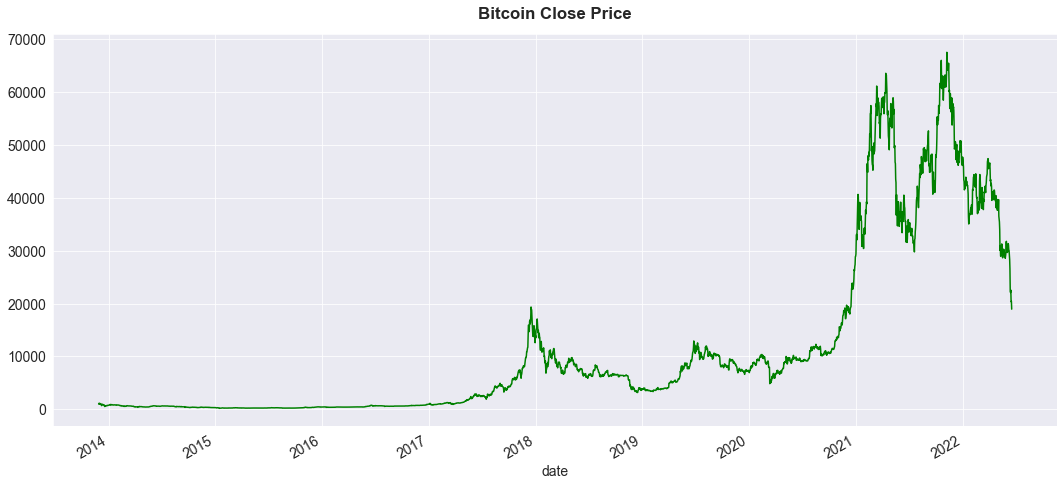

In [401]:
btc_df_viz['close'].plot(color="green") 
plt.title("Bitcoin Close Price", fontweight="bold", y=1.025)#fontname="Times New Roman"
plt.show()

<b> Volume Trend </b>

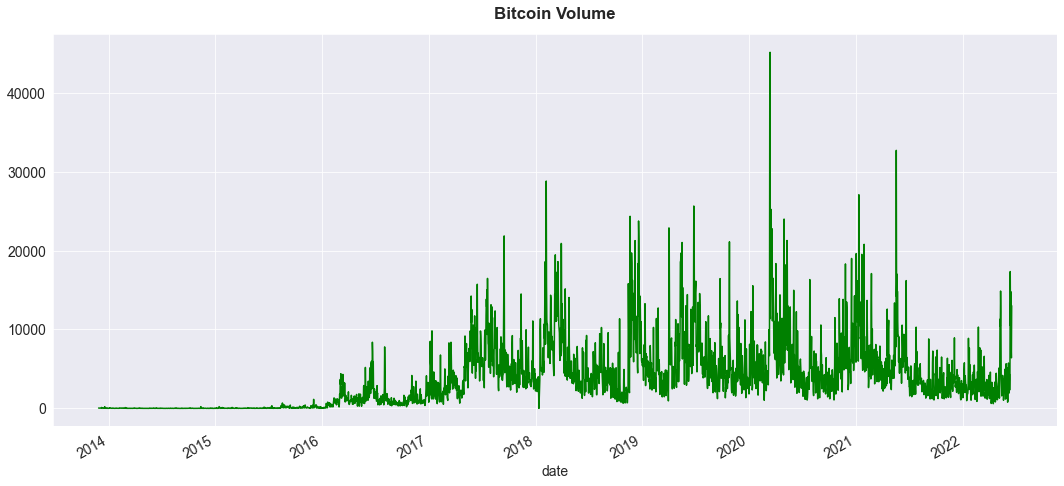

In [402]:
btc_df_viz['volume'].plot(color="green")
plt.title("Bitcoin Volume", fontweight="bold", y=1.025)
plt.show()

<b> Trades Trend </b>

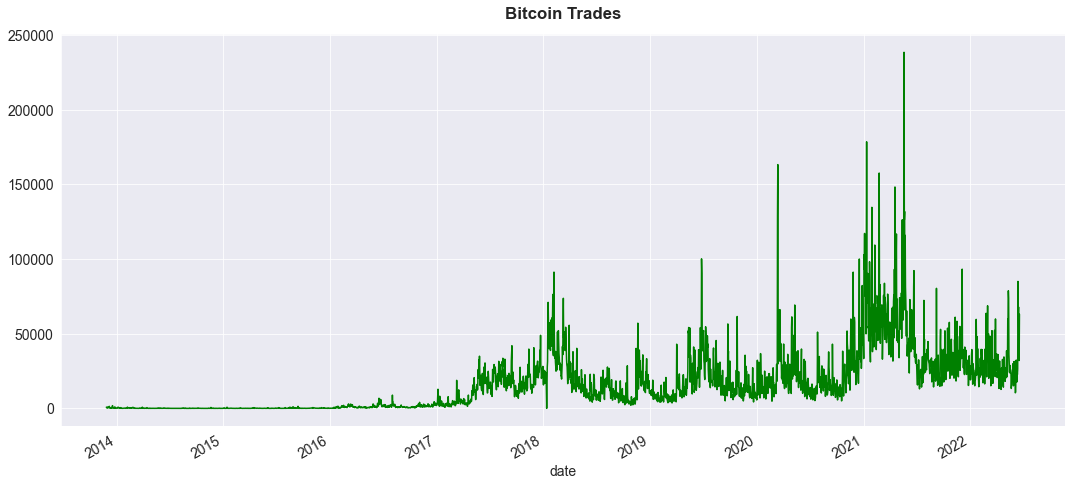

In [403]:
btc_df_viz['trades'].plot(color="green")
plt.title("Bitcoin Trades", fontweight="bold", y=1.025)
plt.show()

<b> Box Plot Close Price </b>

Text(0, 0.5, '')

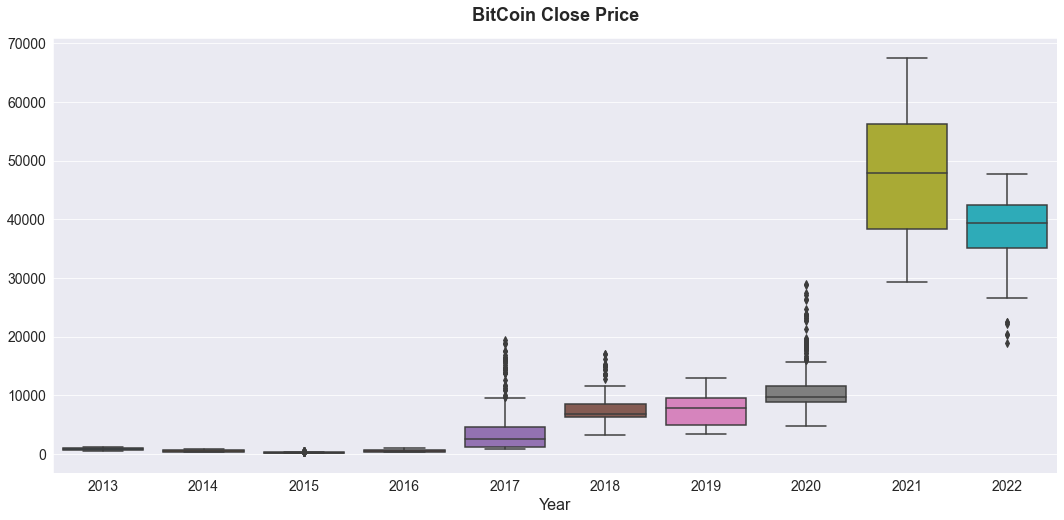

In [404]:
box = sns.boxplot(x=btc_df_viz["year"], y=btc_df_viz["close"], data=btc_df_viz)

box.set_title("BitCoin Close Price",y=1.025, fontdict= {'fontweight':'bold',"fontsize":18})
box.set_xlabel("Year", fontsize=16)
box.set_ylabel(None, fontsize=16)


<b> Box Plot Volume </b>

Text(0, 0.5, '')

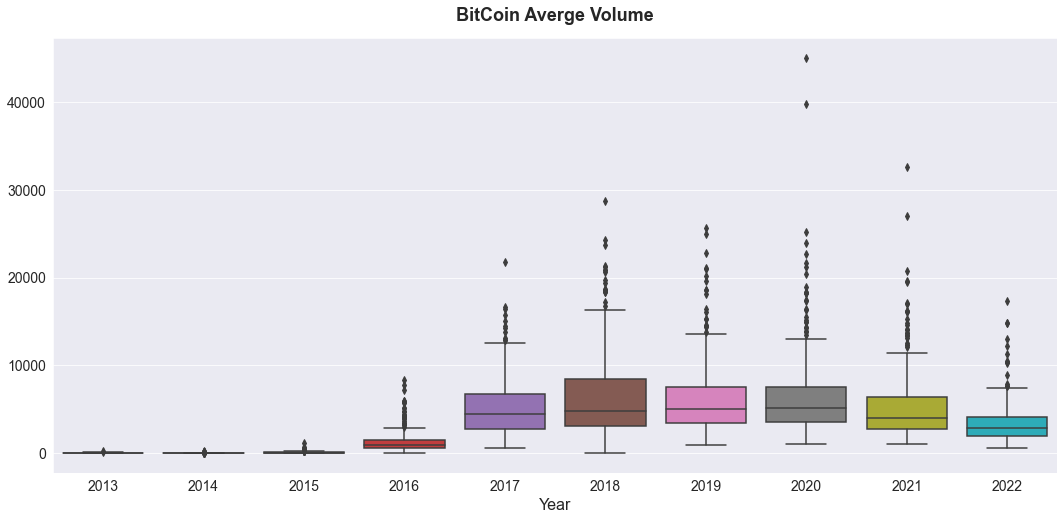

In [405]:
box1 = sns.boxplot(x=btc_df_viz["year"], y=btc_df_viz["volume"], data=btc_df_viz)

box1.set_title("BitCoin Averge Volume",y=1.025, fontdict= {'fontweight':'bold',"fontsize":18})
box1.set_xlabel("Year", fontsize=16)
box1.set_ylabel(None, fontsize=16)


<b> Box Plot Trades </b>

Text(0, 0.5, '')

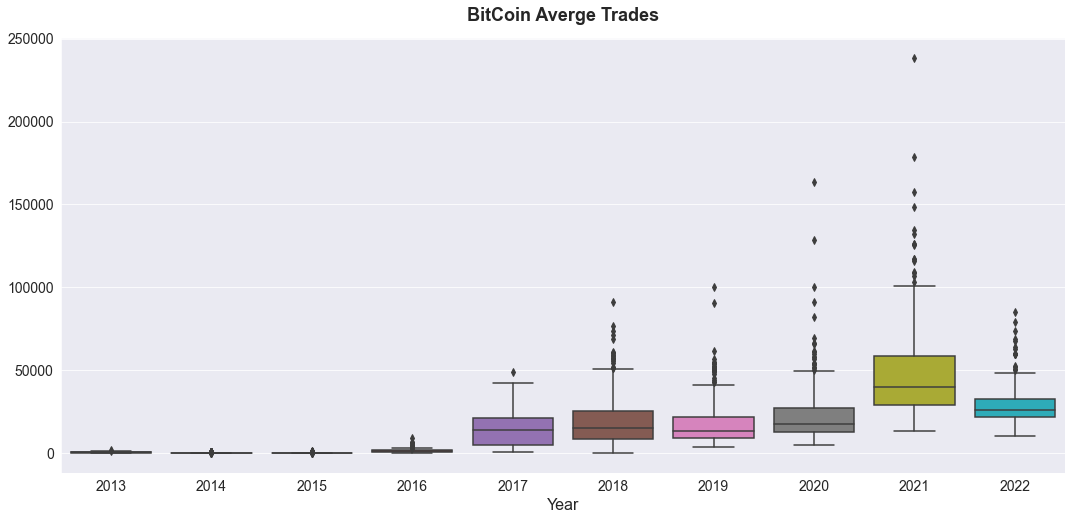

In [406]:
box2 = sns.boxplot(x=btc_df_viz["year"], y=btc_df_viz["trades"], data=btc_df_viz)

box2.set_title("BitCoin Averge Trades",y=1.025, fontdict= {'fontweight':'bold',"fontsize":18})
box2.set_xlabel("Year", fontsize=16)
box2.set_ylabel(None, fontsize=16)

#### 2022 Monthly Close Price 

In [407]:
btc_df_viz_2022 = btc_df_viz[:]

In [408]:
filt = btc_df_viz_2022["year"]='2022'

In [409]:
btc_df_viz_2022 = btc_df_viz_2022[filt]

/var/folders/77/506sgzjs15b84ns9yp8cp2rc0000gn/T/ipykernel_30784/3275679836.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  btc_df_viz_2022 = btc_df_viz_2022[filt]


In [410]:
btc_df_viz_2022.to_csv("data/btc_df_viz_2022.csv")
btc_df_viz_2022.to_excel("data/btc_df_viz_2022.xlsx")

Text(0, 0.5, '')

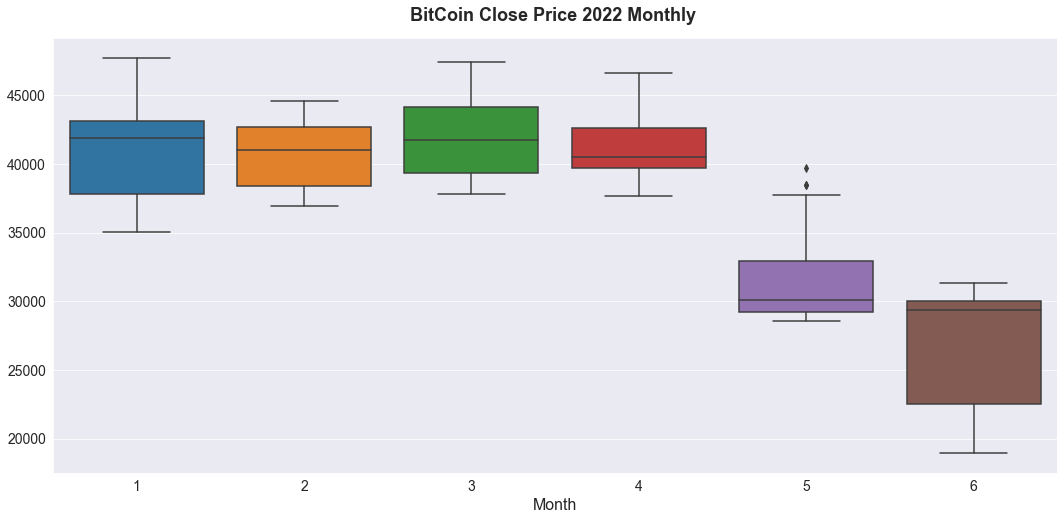

In [411]:
box = sns.boxplot(x=btc_df_viz_2022["month"], y=btc_df_viz_2022["close"], data=btc_df_viz_2022)

box.set_title("BitCoin Close Price 2022 Monthly ",y=1.025, fontdict= {'fontweight':'bold',"fontsize":18})
box.set_xlabel("Month", fontsize=16)
box.set_ylabel(None, fontsize=16)

In [412]:
btc_df_viz = btc_df_viz.astype({"year":"int"})

In [413]:
btc_avg = btc_df_viz[:]
btc_avg.to_csv("data/btc_avg.csv")
btc_avg.to_excel("data/btc_avg.xlsx")
btc_avg

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,2013,11,27,893.90000,1081.09181,890.00000,994.95000,46.413145,782,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,2013,11,28,994.95000,1088.41486,935.08060,1000.32893,33.030364,443,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,2013,11,29,1012.39302,1198.80090,1012.39302,1165.42500,34.827289,562,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814
2013-11-30,2013,11,30,1155.62219,1189.10145,1094.38283,1114.24001,22.761523,365,1012.39302,1198.80090,1012.39302,1165.42500,34.827289,562.0,0.017532,0.101419,0.082680,0.165042,0.054402,0.268623,877.595607,975.675600,837.885186,927.895049,27.908455,393.428571,0.077430,0.064616,0.072709,0.061428,0.299319,0.216921,884.654620,650.853472,375.012714
2013-12-01,2013,12,1,1112.01598,1130.00000,770.00000,953.72943,52.505576,905,1155.62219,1189.10145,1094.38283,1114.24001,22.761523,365.0,0.141476,-0.008091,0.080986,-0.043920,-0.346446,-0.350534,928.920399,1016.393450,884.402399,968.392544,25.006714,412.571429,0.062716,0.061247,0.069921,0.058034,0.414079,0.270971,934.007908,690.715473,394.820714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-14,2022,6,14,22460.00000,23309.00000,20824.00000,22111.00000,10473.220689,59767,26542.20000,26853.20000,21930.40000,22460.10000,17333.488121,85068.0,-0.065281,-0.057809,-0.172641,-0.154669,3.727341,2.215331,29531.528571,29800.828571,27759.771429,28261.357143,5455.616052,33068.142857,-0.006786,-0.007728,-0.014894,-0.016249,0.540214,0.198012,28788.155556,29404.350000,31892.858000
2022-06-15,2022,6,15,22115.00000,22773.30000,20089.00000,22559.60000,14784.405607,67896,22460.00000,23309.00000,20824.00000,22111.00000,10473.220689,59767.0,-0.153800,-0.131984,-0.050451,-0.015543,-0.395781,-0.297421,28261.085714,28623.542857,26563.171429,26977.414286,6130.560395,36981.714286,-0.016383,-0.023390,-0.041337,-0.045265,0.704429,0.382801,27921.866667,29033.885000,31526.308000
2022-06-16,2022,6,16,22557.00000,22950.00000,20200.00000,20366.30000,7892.290963,39183,22115.00000,22773.30000,20089.00000,22559.60000,14784.405607,67896.0,-0.015361,-0.022983,-0.035296,0.020289,0.411639,0.136012,26977.914286,27405.942857,25169.028571,25887.242857,7838.385838,43430.000000,-0.045259,-0.041454,-0.045286,-0.046311,0.552533,0.268123,26944.455556,28702.520000,31215.066000


In [414]:
btc_avg = pd.DataFrame(btc_df_viz.groupby(['year'])['open'].mean())
btc_avg["high"] = pd.DataFrame(btc_df_viz.groupby(['year'])['high'].mean())
btc_avg["low"] = pd.DataFrame(btc_df_viz.groupby(['year'])['low'].mean())
btc_avg["close"] = pd.DataFrame(btc_df_viz.groupby(['year'])['close'].mean())
btc_avg["volume"] = pd.DataFrame(btc_df_viz.groupby(['year'])['volume'].mean())
btc_avg["trades"] = pd.DataFrame(btc_df_viz.groupby(['year'])['trades'].mean())
btc_avg

,open,high,low,close,volume,trades
year,,,,,,
2013,834.430256,887.545685,763.786884,828.310699,43.388851,489.028571
2014,533.016193,548.639927,515.940908,531.499985,14.195329,102.535211
2015,271.471425,278.831813,265.153542,272.323858,77.278983,122.101370
2016,566.870884,576.048015,557.450315,568.276695,1283.666737,1306.759563
2017,3936.776534,4118.183701,3767.023499,3972.502397,5048.121496,14161.161644
2018,7552.732329,7783.027671,7258.388493,7523.407671,6301.052699,19339.312329
2019,7355.562466,7562.660548,7131.104658,7364.964110,6106.849901,17539.893151
2020,11056.251366,11336.646721,10783.763934,11116.068579,6386.292323,22526.715847
2021,47378.112329,48812.425753,45668.609041,47426.086301,5254.154224,47278.846575


<b>Yearly Average Close Price </b>

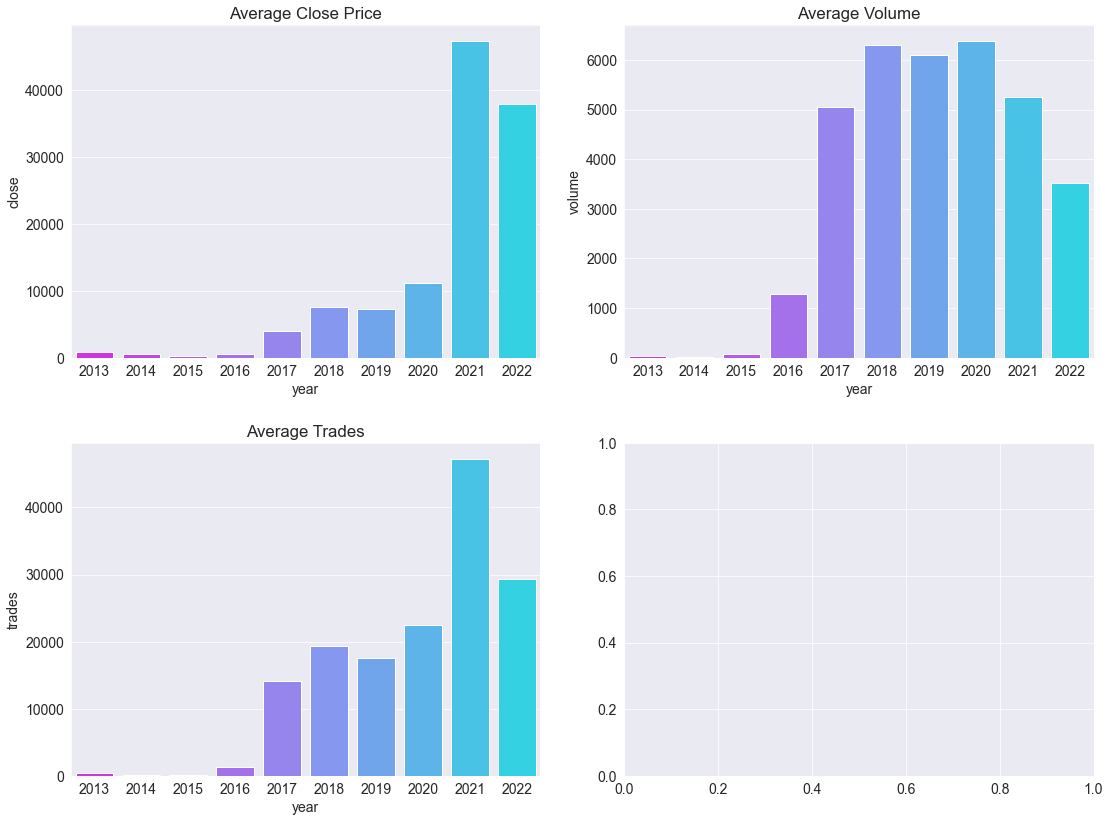

In [415]:
fig, axes = plt.subplots(2,2, figsize=(16,12))

axes[0,0].set_title("Average Close Price")
sns.barplot(ax=axes[0,0], data = btc_avg, x = btc_avg.index, y=btc_avg["close"], palette="cool_r")

axes[0,1].set_title("Average Volume")
sns.barplot(ax=axes[0,1], data = btc_avg, x = btc_avg.index, y=btc_avg["volume"],palette="cool_r")


axes[1,0].set_title("Average Trades",)
sns.barplot(ax=axes[1,0], data = btc_avg, x = btc_avg.index, y=btc_avg["trades"],palette="cool_r")


plt.tight_layout(pad=2)

In [416]:
#df_2013 = btc_df_viz[btc_df_viz["year"]==2013]
#df_2014 = btc_df_viz[btc_df_viz["year"]==2014]
#df_2015 = btc_df_viz[btc_df_viz["year"]==2015]
#df_2016 = btc_df_viz[btc_df_viz["year"]==2016]
#df_2017 = btc_df_viz[btc_df_viz["year"]==2017]
#df_2018 = btc_df_viz[btc_df_viz["year"]==2018]
#df_2019 = btc_df_viz[btc_df_viz["year"]==2019]
#df_2020 = btc_df_viz[btc_df_viz["year"]==2020]
#df_2021 = btc_df_viz[btc_df_viz["year"]==2021]
#df_2022 = btc_df_viz[btc_df_viz["year"]==2022]

#### Heatmap showing  correlation score

In [417]:
cor_df= btc_df_viz.corr()

<AxesSubplot:>

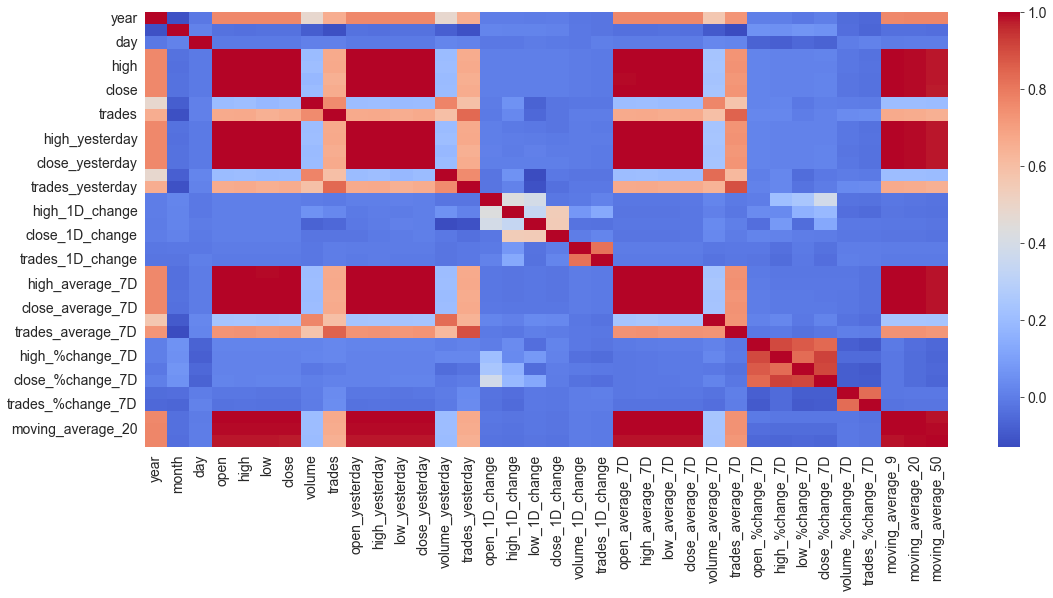

In [418]:
sns.heatmap(cor_df, cmap="coolwarm")

#### DataFrame with Dropping some Features

In [419]:
btc_df_less_features = btc_df.drop(["year", "month", "day"], axis=1) # not important

In [420]:
btc_df_less_features = btc_df_less_features.drop(["open", "high", "low","trades", "volume"], axis=1) 

# in reality, we don't know this on the current day or tomorrow day we want to predict
# we only know yesterday'open, yesterday'high, yesterday's low, and yesterday's close

In [421]:
btc_df_less_features.head(3)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,994.95000,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,1000.32893,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,1165.42500,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814


<b> Save dataframe for machine learning model </b>

In [422]:
btc_df_less_features.to_csv("data/btc_df_less_features.csv")

## MACHINE LEARNING MODEL

* Split train-test data using date since it's a time series data

* not using train-test-split from sklearn since it will mix up the data

In [423]:
btc_ml_all = pd.read_csv("data/btc_df_less_features.csv", index_col=0)

In [424]:
btc_ml_all.head(3)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,994.95000,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,1000.32893,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,1165.42500,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814


In [425]:
btc_ml_all.tail(3)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-17,20432.9,22557.0,22950.0,20200.0,20366.3,7892.290963,39183.0,0.019986,0.007759,0.005525,-0.097222,-0.466175,-0.422897,25887.371429,26303.657143,23784.428571,24500.242857,8688.708203,46507.428571,-0.046288,-0.043590,-0.053497,-0.039242,0.683878,0.329980,25751.977778,28291.835,30837.394
2022-06-18,18950.0,20366.3,21327.2,20231.3,20432.9,6404.169867,32072.0,-0.097118,-0.070710,0.001550,0.003270,-0.188554,-0.181482,24498.942857,25017.885714,22553.871429,23268.528571,8981.699997,47590.428571,-0.039269,-0.039603,-0.052919,-0.052585,0.662194,0.301687,24667.766667,27862.480,30450.996
2022-06-19,18276.0,20440.3,20740.1,17600.0,18950.0,13006.203311,63068.0,0.003633,-0.027528,-0.130061,-0.072574,1.030896,0.966450,23268.100000,23779.085714,21054.457143,21921.357143,10508.632172,53358.714286,-0.052644,-0.048128,-0.047694,-0.047271,0.457558,0.220289,23431.622222,27337.460,30058.006


#### Drop the last row because we want to predict the price of the current day

In [426]:
last_row = btc_ml_all[-1:]
last_row

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-19,18276.0,20440.3,20740.1,17600.0,18950.0,13006.203311,63068.0,0.003633,-0.027528,-0.130061,-0.072574,1.030896,0.96645,23268.1,23779.085714,21054.457143,21921.357143,10508.632172,53358.714286,-0.052644,-0.048128,-0.047694,-0.047271,0.457558,0.220289,23431.622222,27337.46,30058.006


In [427]:
btc_ml = btc_ml_all[:-1]
btc_ml.head(2)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,994.95000,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,1000.32893,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435


In [428]:
btc_ml.tail(2)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-17,20432.9,22557.0,22950.0,20200.0,20366.3,7892.290963,39183.0,0.019986,0.007759,0.005525,-0.097222,-0.466175,-0.422897,25887.371429,26303.657143,23784.428571,24500.242857,8688.708203,46507.428571,-0.046288,-0.043590,-0.053497,-0.039242,0.683878,0.329980,25751.977778,28291.835,30837.394
2022-06-18,18950.0,20366.3,21327.2,20231.3,20432.9,6404.169867,32072.0,-0.097118,-0.070710,0.001550,0.003270,-0.188554,-0.181482,24498.942857,25017.885714,22553.871429,23268.528571,8981.699997,47590.428571,-0.039269,-0.039603,-0.052919,-0.052585,0.662194,0.301687,24667.766667,27862.480,30450.996


#### Split train-test 85:15
* Can't use train-test split because it will shuffle the data/date index

In [429]:
len(btc_ml)

3116

In [430]:
train_size = (85*(len(btc_ml)))//100
train_size

2648

**Train Set**

In [431]:
train_set = btc_ml.iloc[0:train_size]
train_set.tail(3)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-05,48734.7,50400.0,51820.4,47500.0,48330.0,7226.225287,69346.0,0.039263,-0.014821,-0.013704,-0.041071,0.075076,0.074499,47612.728571,49709.928571,45702.885714,47795.285714,6848.919611,62119.428571,-0.000238,0.004100,0.004170,0.002953,0.044719,0.014825,47928.466667,50024.55,42162.606
2021-03-06,48899.9,48330.0,49539.3,46312.0,48734.7,7480.677506,66327.0,-0.041071,-0.044019,-0.025011,0.008374,0.035212,-0.043535,47792.428571,49865.685714,46015.985714,48141.028571,6481.739528,59746.857143,0.002957,0.000235,0.003166,0.004746,0.065777,0.036629,47818.133333,50101.29,42354.268
2021-03-07,50962.3,48767.4,49232.2,47111.9,48899.9,3104.707568,32986.0,0.009050,-0.006199,0.017272,0.003390,-0.584970,-0.502676,48143.885714,49991.714286,46314.414286,48530.985714,6320.190757,58221.571429,0.004714,0.003886,0.007490,0.008209,0.022819,0.002121,48022.400000,50113.80,42597.470


**Test Set**

In [432]:
test_set = btc_ml[train_size:]
test_set.head(3)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-08,52375.0,48906.0,51470.2,48905.9,50962.3,4519.006019,44562.0,0.002842,0.045458,0.038080,0.042176,0.455534,0.350937,48535.614286,50672.285714,47155.257143,49347.685714,5988.564122,56316.428571,0.008328,0.003292,0.007035,0.009139,0.021908,-0.002043,48538.822222,50265.060,42896.424
2021-03-09,54929.0,50971.3,52432.9,49368.0,52375.0,4669.972212,49052.0,0.042230,0.018704,0.009449,0.027720,0.033407,0.100758,49355.128571,51045.828571,47772.571429,49741.157143,5645.571552,54516.142857,0.009177,0.014643,0.018830,0.018025,-0.000872,0.001517,49228.244444,50422.875,43227.596
2021-03-10,55851.0,52383.0,54929.0,51875.0,54929.0,5890.742509,59580.0,0.027696,0.047606,0.050782,0.048764,0.261408,0.214629,49750.514286,51717.714286,48461.828571,50661.557143,5658.989103,55198.714286,0.018085,0.007797,0.013450,0.008171,-0.000914,0.006643,50304.200000,50562.825,43593.726


**X_train, y_train, X_test, y_test**

<b>X_train</b>

In [433]:
X_train_new = train_set.drop(["close"], axis=1)
X_train_new.head(3)

,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814


In [434]:
X_train = X_train_new.values
X_train.shape

(2648, 27)

<b>X_test</b>

In [435]:
X_test_new = test_set.drop(["close"], axis=1)

In [436]:
X_test_new.head(3)

,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-08,48906.0,51470.2,48905.9,50962.3,4519.006019,44562.0,0.002842,0.045458,0.038080,0.042176,0.455534,0.350937,48535.614286,50672.285714,47155.257143,49347.685714,5988.564122,56316.428571,0.008328,0.003292,0.007035,0.009139,0.021908,-0.002043,48538.822222,50265.060,42896.424
2021-03-09,50971.3,52432.9,49368.0,52375.0,4669.972212,49052.0,0.042230,0.018704,0.009449,0.027720,0.033407,0.100758,49355.128571,51045.828571,47772.571429,49741.157143,5645.571552,54516.142857,0.009177,0.014643,0.018830,0.018025,-0.000872,0.001517,49228.244444,50422.875,43227.596
2021-03-10,52383.0,54929.0,51875.0,54929.0,5890.742509,59580.0,0.027696,0.047606,0.050782,0.048764,0.261408,0.214629,49750.514286,51717.714286,48461.828571,50661.557143,5658.989103,55198.714286,0.018085,0.007797,0.013450,0.008171,-0.000914,0.006643,50304.200000,50562.825,43593.726


In [437]:
X_test = X_test_new.values
X_test.shape

(468, 27)

<b> y_train </b>

In [438]:
y_train_new = train_set["close"]

In [439]:
y_train = y_train_new.values
y_train.shape

(2648,)

<b>y_test</b>

In [440]:
y_test_new = test_set["close"]
y_test = y_test_new.values
y_test.shape

(468,)

## Support Vector Machine

In [441]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics  import mean_squared_error, r2_score
from sklearn.svm import SVR

### Scale featues

In [442]:
scaler = StandardScaler()

In [443]:
X_scaled_train = scaler.fit_transform(X_train)

In [444]:
X_scaled_test = scaler.transform(X_test) 
# not using fit to avoid data leakage 

### Base Model1:  Not Scale and Not Adjust Parameters

In [445]:
svr_base1 = SVR()

In [446]:
svr_base1.fit(X_train , y_train)

SVR()

In [447]:
pred_base1 = svr_base1.predict(X_test)

In [448]:
print(np.sqrt(mean_squared_error(y_test, pred_base1)))

43307.89226005868


In [449]:
print(r2_score(y_test, pred_base1))

-17.721148500704274


### Base Model2: Scale but Not Adjust Parameters

In [450]:
svr_base2 = SVR()

In [451]:
svr_base2.fit(X_scaled_train, y_train)

SVR()

In [452]:
pred_base2 = svr_base2.predict(X_scaled_test)

In [453]:
print(np.sqrt(mean_squared_error(y_test, pred_base2)))

43261.30994768422


In [454]:
print(r2_score(y_test, pred_base2))

-17.680896928211624


### Model 3: Adjusted Model: Scale + Adjust Parameters

In [455]:
param_grid = {'kernel': ['linear'], 'C': [100,300, 500], 'epsilon': [0.00001, 0.0001, 0.001]}

In [456]:
svr = SVR()

In [457]:
%%time
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='r2')

CPU times: user 86 µs, sys: 700 µs, total: 786 µs
Wall time: 1.4 ms


In [458]:
%%time
grid_search.fit(X_scaled_train, y_train)

CPU times: user 1min 17s, sys: 678 ms, total: 1min 17s
Wall time: 1min 21s


GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [100, 300, 500],
                         'epsilon': [1e-05, 0.0001, 0.001],
                         'kernel': ['linear']},
             scoring='r2')

In [459]:
%%time
print(grid_search.best_params_)

{'C': 500, 'epsilon': 0.001, 'kernel': 'linear'}
CPU times: user 141 µs, sys: 33 µs, total: 174 µs
Wall time: 143 µs


In [460]:
svr_best = grid_search.best_estimator_

In [461]:
pred_svr_adjusted = svr_best.predict(X_scaled_test)

In [462]:
print(np.sqrt(mean_squared_error(y_test, pred_svr_adjusted)))

1746.6864794699031


In [463]:
print(r2_score(y_test, pred_svr_adjusted))

0.9695471242948882


In [464]:
len(y_test)

468

In [465]:
len(pred_svr_adjusted)

468

In [466]:
test_set["close"]

date
2021-03-08    52375.0
2021-03-09    54929.0
2021-03-10    55851.0
2021-03-11    57809.9
2021-03-12    57234.0
               ...   
2022-06-14    22111.0
2022-06-15    22559.6
2022-06-16    20366.3
2022-06-17    20432.9
2022-06-18    18950.0
Name: close, Length: 468, dtype: float64

In [467]:
df_compare = pd.DataFrame(columns=["actual_price", "predicted_price"])

In [468]:
df_compare

,actual_price,predicted_price


In [469]:
df_compare["actual_price"] = test_set["close"]

In [470]:
df_compare["predicted_price"] = pred_svr_adjusted

In [471]:
df_compare["difference"] =  df_compare["actual_price"] - df_compare["predicted_price"] 

In [472]:
df_compare.head(10)

,actual_price,predicted_price,difference
date,,,
2021-03-08,52375.0,50683.110870,1691.889130
2021-03-09,54929.0,51778.407336,3150.592664
2021-03-10,55851.0,54356.640847,1494.359153
2021-03-11,57809.9,55711.421621,2098.478379
2021-03-12,57234.0,57268.185138,-34.185138
2021-03-13,61174.9,57136.728419,4038.171581
2021-03-14,59001.1,60362.683505,-1361.583505
2021-03-15,55600.0,59880.897637,-4280.897637
2021-03-16,56891.1,56722.547194,168.552806


In [473]:
df_compare.tail(15)

,actual_price,predicted_price,difference
date,,,
2022-06-04,29850.0,29750.412764,99.587236
2022-06-05,29907.6,29735.223901,172.376099
2022-06-06,31356.3,29826.574870,1529.725130
2022-06-07,31098.6,31044.118926,54.481074
2022-06-08,30190.8,30717.340815,-526.540815
2022-06-09,30075.3,30326.020319,-250.720319
2022-06-10,29054.9,30126.668080,-1071.768080
2022-06-11,28380.2,29248.938147,-868.738147
2022-06-12,26569.6,28494.307040,-1924.707040


In [474]:
df_compare.to_csv("data/df_compare.csv")
df_compare.to_excel("data/df_compare.xlsx")

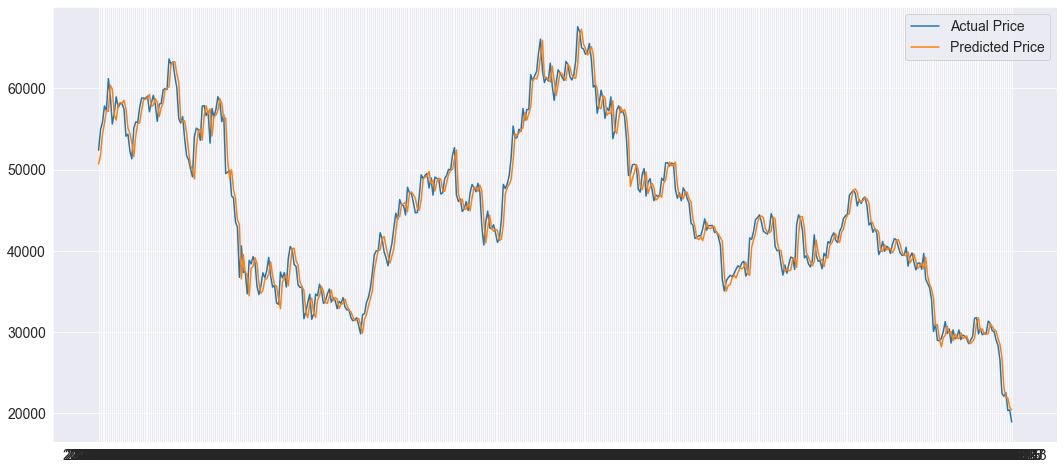

In [475]:
plt.plot(df_compare.index , df_compare.actual_price, label="Actual Price")
plt.plot(df_compare.index , df_compare.predicted_price, label="Predicted Price")
plt.legend()
plt.show()


# LIVE PREDICTION

* This section is trying to test the model performance on live prediction
* The model will predict the price the next day
* Therefore, there will be only one row of test set 
* y_test will be known at the end of trading day

#### 1. Dataset is from 2013 to Current day

In [476]:
btc_ml.head(2)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,994.95000,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,1000.32893,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435


In [477]:
btc_ml.tail(2)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-17,20432.9,22557.0,22950.0,20200.0,20366.3,7892.290963,39183.0,0.019986,0.007759,0.005525,-0.097222,-0.466175,-0.422897,25887.371429,26303.657143,23784.428571,24500.242857,8688.708203,46507.428571,-0.046288,-0.043590,-0.053497,-0.039242,0.683878,0.329980,25751.977778,28291.835,30837.394
2022-06-18,18950.0,20366.3,21327.2,20231.3,20432.9,6404.169867,32072.0,-0.097118,-0.070710,0.001550,0.003270,-0.188554,-0.181482,24498.942857,25017.885714,22553.871429,23268.528571,8981.699997,47590.428571,-0.039269,-0.039603,-0.052919,-0.052585,0.662194,0.301687,24667.766667,27862.480,30450.996


#### 2. Training Set is from 2013 to yesterday price

<b> X_train</b>

In [478]:
X_train_new2 = btc_ml.drop(["close"], axis=1)
X_train_new2.head(2)

,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435


In [479]:
X_train_new2.tail(2)

,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-17,22557.0,22950.0,20200.0,20366.3,7892.290963,39183.0,0.019986,0.007759,0.005525,-0.097222,-0.466175,-0.422897,25887.371429,26303.657143,23784.428571,24500.242857,8688.708203,46507.428571,-0.046288,-0.043590,-0.053497,-0.039242,0.683878,0.329980,25751.977778,28291.835,30837.394
2022-06-18,20366.3,21327.2,20231.3,20432.9,6404.169867,32072.0,-0.097118,-0.070710,0.001550,0.003270,-0.188554,-0.181482,24498.942857,25017.885714,22553.871429,23268.528571,8981.699997,47590.428571,-0.039269,-0.039603,-0.052919,-0.052585,0.662194,0.301687,24667.766667,27862.480,30450.996


In [480]:
X_train2 = X_train_new2.values
X_train2.shape

(3116, 27)

<b> y_train </b>

In [481]:
y_train_new = btc_ml["close"]
y_train2 = y_train_new.values
y_train2.shape

(3116,)

#### 3. Test set is current trading day , today ( the last row)

In [482]:
X_test2 = last_row.drop(["close"], axis=1)
X_test2

,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-19,20440.3,20740.1,17600.0,18950.0,13006.203311,63068.0,0.003633,-0.027528,-0.130061,-0.072574,1.030896,0.96645,23268.1,23779.085714,21054.457143,21921.357143,10508.632172,53358.714286,-0.052644,-0.048128,-0.047694,-0.047271,0.457558,0.220289,23431.622222,27337.46,30058.006


<b> y_actual </b>

#### 4. Model Prediciton

In [483]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics  import mean_squared_error, r2_score
from sklearn.svm import SVR

### Scale featues

In [484]:
scaler = StandardScaler()

In [485]:
X_scaled_train2 = scaler.fit_transform(X_train2)

In [486]:
X_scaled_test2 = scaler.transform(X_test2) # not using fit to avoid data leakage 

/Users/daranee/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [487]:
param_grid2 = {'kernel': ['linear'], 'C': [100,300, 500], 'epsilon': [0.00001, 0.0001, 0.001]}

In [488]:
svr2 = SVR()

In [489]:
%%time
grid_search2 = GridSearchCV(svr2, param_grid2, cv=5, scoring='r2')

CPU times: user 767 µs, sys: 863 µs, total: 1.63 ms
Wall time: 3.14 ms


In [490]:
%%time
grid_search2.fit(X_scaled_train2, y_train2)

CPU times: user 1min 20s, sys: 393 ms, total: 1min 20s
Wall time: 1min 21s


GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [100, 300, 500],
                         'epsilon': [1e-05, 0.0001, 0.001],
                         'kernel': ['linear']},
             scoring='r2')

In [491]:
%%time
print(grid_search2.best_params_)

{'C': 500, 'epsilon': 0.001, 'kernel': 'linear'}
CPU times: user 172 µs, sys: 86 µs, total: 258 µs
Wall time: 169 µs


In [492]:
svr_best2 = grid_search2.best_estimator_

In [493]:
pred_svr_adjusted2 = svr_best2.predict(X_scaled_test2)

In [494]:
pred_svr_adjusted2

array([19130.52569225])

#### Create a new dataframe 

In [495]:
new_cols = ["date","predict", "actual"]

In [496]:
df_actual = pd.DataFrame(columns=new_cols)
df_actual

,date,predict,actual


In [497]:
df_actual["date"] = last_row.index
df_actual

,date,predict,actual
0,2022-06-19,NaN,NaN


In [498]:
df_actual["predict"] = pred_svr_adjusted2
df_actual

,date,predict,actual
0,2022-06-19,19130.525692,NaN


## Run Every Day

### Run at the End Of Day ( 5 p.m. Pacific Time)

In [499]:
daily_predict = pd.read_csv("data/daily_predict.csv", index_col=0)
daily_predict

,date,predict,actual,difference
0,2022-05-26,29070.000000,29186.9,-116.900000
1,2022-05-27,28970.105130,28580.0,390.105130
2,2022-05-28,28707.510872,29020.0,-312.489128
3,2022-05-29,28931.565188,29450.4,-518.834812
4,2022-05-30,29302.727938,31711.7,-2408.972062
5,2022-05-31,31233.164985,31780.9,-547.735015
6,2022-06-01,31797.861554,29790.0,2007.861554
7,2022-06-02,30229.524306,30427.0,-197.475694
8,2022-06-03,30475.550098,29676.4,799.150098
9,2022-06-04,29829.815486,29850.0,-20.184514


### Actual Result

In [500]:
actual_close = btc_ml["close"][-1]
actual_close

18950.0

In [501]:
#daily_predict.set_index("date")

In [502]:
daily_predict["actual"][-1:] =  actual_close
daily_predict

/var/folders/77/506sgzjs15b84ns9yp8cp2rc0000gn/T/ipykernel_30784/2655483848.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_predict["actual"][-1:] =  actual_close


,date,predict,actual,difference
0,2022-05-26,29070.000000,29186.9,-116.900000
1,2022-05-27,28970.105130,28580.0,390.105130
2,2022-05-28,28707.510872,29020.0,-312.489128
3,2022-05-29,28931.565188,29450.4,-518.834812
4,2022-05-30,29302.727938,31711.7,-2408.972062
5,2022-05-31,31233.164985,31780.9,-547.735015
6,2022-06-01,31797.861554,29790.0,2007.861554
7,2022-06-02,30229.524306,30427.0,-197.475694
8,2022-06-03,30475.550098,29676.4,799.150098
9,2022-06-04,29829.815486,29850.0,-20.184514


In [503]:
daily_predict["difference"] = daily_predict["predict"] - daily_predict["actual"]
daily_predict

,date,predict,actual,difference
0,2022-05-26,29070.000000,29186.9,-116.900000
1,2022-05-27,28970.105130,28580.0,390.105130
2,2022-05-28,28707.510872,29020.0,-312.489128
3,2022-05-29,28931.565188,29450.4,-518.834812
4,2022-05-30,29302.727938,31711.7,-2408.972062
5,2022-05-31,31233.164985,31780.9,-547.735015
6,2022-06-01,31797.861554,29790.0,2007.861554
7,2022-06-02,30229.524306,30427.0,-197.475694
8,2022-06-03,30475.550098,29676.4,799.150098
9,2022-06-04,29829.815486,29850.0,-20.184514


### Store Updated data everyday

In [344]:
daily_predict = daily_predict.append(df_actual, ignore_index=True)
daily_predict

/var/folders/77/506sgzjs15b84ns9yp8cp2rc0000gn/T/ipykernel_30784/4107255893.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  daily_predict = daily_predict.append(df_actual, ignore_index=True)


,date,predict,actual,difference
0,2022-05-26,29070.000000,29186.9,-116.900000
1,2022-05-27,28970.105130,28580.0,390.105130
2,2022-05-28,28707.510872,29020.0,-312.489128
3,2022-05-29,28931.565188,29450.4,-518.834812
4,2022-05-30,29302.727938,31711.7,-2408.972062
5,2022-05-31,31233.164985,31780.9,-547.735015
6,2022-06-01,31797.861554,29790.0,2007.861554
7,2022-06-02,30229.524306,30427.0,-197.475694
8,2022-06-03,30475.550098,29676.4,799.150098
9,2022-06-04,29829.815486,29850.0,-20.184514


In [345]:
daily_predict.to_csv("data/daily_predict.csv")